In [15]:
from qiskit import QuantumCircuit, QuantumRegister
import os, sys
import numpy
import random
from tqdm import tqdm
import rustworkx
import json
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, partial_trace

if not '../' in sys.path:
    sys.path.insert(1, '../')

In [16]:
from helperfunctions.circuitgraphfunctions import get_computation_graph, get_uncomp_circuit
from helperfunctions.uncompfunctions import add_uncomputation, exhaustive_uncomputation_adding, greedy_uncomputation_full, greedy_uncomputation_partial
from helperfunctions.graphhelper import edge_attr, edge_matcher,node_attr,node_matcher, breakdown_qubit
from helperfunctions.measurecircuit import get_statevector, get_probability_from_statevector, zero_ancillas_in_statevector, print_probs
from helperfunctions.constants import UncompType
from helperfunctions.randomcircuit import random_quantum_circuit_large_with_params, get_ancillas_of_circuit
from helperfunctions.evaluation import get_difference_in_prob, ProbDiffResults
from helperfunctions.matplotlib_basic_units import radians
import matplotlib.colors as mcolors

from rustworkx.visualization import graphviz_draw

In [17]:
invalid_circuit = QuantumCircuit(2)
invalid_circuit.x(0)
invalid_circuit.h(0)
invalid_circuit.cx(0,1)
invalid_circuit.cx(1,0)
print(invalid_circuit)

     ┌───┐┌───┐     ┌───┐
q_0: ┤ X ├┤ H ├──■──┤ X ├
     └───┘└───┘┌─┴─┐└─┬─┘
q_1: ──────────┤ X ├──■──
               └───┘     


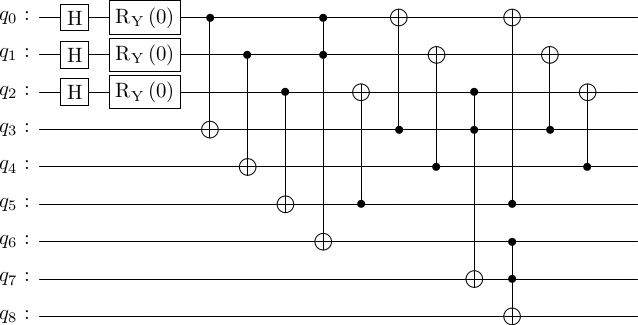

In [18]:
def get_valid_circ(theta=0.0):
    valid_circuitq = QuantumCircuit(9)
    for i in range(3):
        valid_circuitq.h(i)
        valid_circuitq.ry(theta*i/3, i)
        valid_circuitq.cx(i,i+3)
    valid_circuitq.ccx(0,1,6)

    for i in range(3):
        valid_circuitq.cx(i+3,i)
    
    valid_circuitq.ccx(2,3,7)
    
    valid_circuitq.cx(3,1)
    valid_circuitq.cx(4,2)
    valid_circuitq.cx(5,0)

    
    valid_circuitq.ccx(6,7,8)

    return valid_circuitq, 3,6,12

valid_circuitq,q,a,g = get_valid_circ()
valid_circuitq.draw('latex')    

In [19]:

valid_ancillas = get_ancillas_of_circuit(valid_circuitq, 6)
print(valid_ancillas)

['q3', 'q4', 'q5', 'q6', 'q7', 'q8']


In [20]:
val_sv = Statevector(valid_circuitq)
for i,p in val_sv.probabilities_dict().items():
    print(i, p)

000000000 0.12499999999999994
000001010 0.12499999999999994
000010100 0.12499999999999994
000100001 0.12499999999999994
000101011 0.12499999999999994
000110101 0.12499999999999994
001011110 0.12499999999999994
001111111 0.12499999999999994


In [21]:
print_probs(val_sv, is_statevector=True)

|000000000> : 0.125, |000000001> : 0.000, |000000010> : 0.000, |000000011> : 0.000, 
|000000100> : 0.000, |000000101> : 0.000, |000000110> : 0.000, |000000111> : 0.000, 
|000001000> : 0.000, |000001001> : 0.000, |000001010> : 0.125, |000001011> : 0.000, 
|000001100> : 0.000, |000001101> : 0.000, |000001110> : 0.000, |000001111> : 0.000, 
|000010000> : 0.000, |000010001> : 0.000, |000010010> : 0.000, |000010011> : 0.000, 
|000010100> : 0.125, |000010101> : 0.000, |000010110> : 0.000, |000010111> : 0.000, 
|000011000> : 0.000, |000011001> : 0.000, |000011010> : 0.000, |000011011> : 0.000, 
|000011100> : 0.000, |000011101> : 0.000, |000011110> : 0.000, |000011111> : 0.000, 
|000100000> : 0.000, |000100001> : 0.125, |000100010> : 0.000, |000100011> : 0.000, 
|000100100> : 0.000, |000100101> : 0.000, |000100110> : 0.000, |000100111> : 0.000, 
|000101000> : 0.000, |000101001> : 0.000, |000101010> : 0.000, |000101011> : 0.125, 
|000101100> : 0.000, |000101101> : 0.000, |000101110> : 0.000, |0

'|000000000> : 0.125, |000000001> : 0.000, |000000010> : 0.000, |000000011> : 0.000, \n|000000100> : 0.000, |000000101> : 0.000, |000000110> : 0.000, |000000111> : 0.000, \n|000001000> : 0.000, |000001001> : 0.000, |000001010> : 0.125, |000001011> : 0.000, \n|000001100> : 0.000, |000001101> : 0.000, |000001110> : 0.000, |000001111> : 0.000, \n|000010000> : 0.000, |000010001> : 0.000, |000010010> : 0.000, |000010011> : 0.000, \n|000010100> : 0.125, |000010101> : 0.000, |000010110> : 0.000, |000010111> : 0.000, \n|000011000> : 0.000, |000011001> : 0.000, |000011010> : 0.000, |000011011> : 0.000, \n|000011100> : 0.000, |000011101> : 0.000, |000011110> : 0.000, |000011111> : 0.000, \n|000100000> : 0.000, |000100001> : 0.125, |000100010> : 0.000, |000100011> : 0.000, \n|000100100> : 0.000, |000100101> : 0.000, |000100110> : 0.000, |000100111> : 0.000, \n|000101000> : 0.000, |000101001> : 0.000, |000101010> : 0.000, |000101011> : 0.125, \n|000101100> : 0.000, |000101101> : 0.000, |000101110>

In [22]:
zero_ancillas = zero_ancillas_in_statevector(val_sv, 6)
print(zero_ancillas)

[3.53553391e-01+0.j 3.53553391e-01+0.j 3.53553391e-01+0.j
 3.53553391e-01+0.j 3.53553391e-01+0.j 3.53553391e-01+0.j
 3.53553391e-01+0.j 3.53553391e-01+0.j 1.00000000e-10+0.j
 1.00000000e-10+0.j 1.00000000e-10+0.j 1.00000000e-10+0.j
 1.00000000e-10+0.j 1.00000000e-10+0.j 1.00000000e-10+0.j
 1.00000000e-10+0.j 1.00000000e-10+0.j 1.00000000e-10+0.j
 1.00000000e-10+0.j 1.00000000e-10+0.j 1.00000000e-10+0.j
 1.00000000e-10+0.j 1.00000000e-10+0.j 1.00000000e-10+0.j
 1.00000000e-10+0.j 1.00000000e-10+0.j 1.00000000e-10+0.j
 1.00000000e-10+0.j 1.00000000e-10+0.j 1.00000000e-10+0.j
 1.00000000e-10+0.j 1.00000000e-10+0.j 1.00000000e-10+0.j
 1.00000000e-10+0.j 1.00000000e-10+0.j 1.00000000e-10+0.j
 1.00000000e-10+0.j 1.00000000e-10+0.j 1.00000000e-10+0.j
 1.00000000e-10+0.j 1.00000000e-10+0.j 1.00000000e-10+0.j
 1.00000000e-10+0.j 1.00000000e-10+0.j 1.00000000e-10+0.j
 1.00000000e-10+0.j 1.00000000e-10+0.j 1.00000000e-10+0.j
 1.00000000e-10+0.j 1.00000000e-10+0.j 1.00000000e-10+0.j
 1.00000000e-1

In [23]:
print_probs(zero_ancillas, is_statevector=True)

|000000000> : 0.125, |000000001> : 0.125, |000000010> : 0.125, |000000011> : 0.125, 
|000000100> : 0.125, |000000101> : 0.125, |000000110> : 0.125, |000000111> : 0.125, 
|000001000> : 0.000, |000001001> : 0.000, |000001010> : 0.000, |000001011> : 0.000, 
|000001100> : 0.000, |000001101> : 0.000, |000001110> : 0.000, |000001111> : 0.000, 
|000010000> : 0.000, |000010001> : 0.000, |000010010> : 0.000, |000010011> : 0.000, 
|000010100> : 0.000, |000010101> : 0.000, |000010110> : 0.000, |000010111> : 0.000, 
|000011000> : 0.000, |000011001> : 0.000, |000011010> : 0.000, |000011011> : 0.000, 
|000011100> : 0.000, |000011101> : 0.000, |000011110> : 0.000, |000011111> : 0.000, 
|000100000> : 0.000, |000100001> : 0.000, |000100010> : 0.000, |000100011> : 0.000, 
|000100100> : 0.000, |000100101> : 0.000, |000100110> : 0.000, |000100111> : 0.000, 
|000101000> : 0.000, |000101001> : 0.000, |000101010> : 0.000, |000101011> : 0.000, 
|000101100> : 0.000, |000101101> : 0.000, |000101110> : 0.000, |0

'|000000000> : 0.125, |000000001> : 0.125, |000000010> : 0.125, |000000011> : 0.125, \n|000000100> : 0.125, |000000101> : 0.125, |000000110> : 0.125, |000000111> : 0.125, \n|000001000> : 0.000, |000001001> : 0.000, |000001010> : 0.000, |000001011> : 0.000, \n|000001100> : 0.000, |000001101> : 0.000, |000001110> : 0.000, |000001111> : 0.000, \n|000010000> : 0.000, |000010001> : 0.000, |000010010> : 0.000, |000010011> : 0.000, \n|000010100> : 0.000, |000010101> : 0.000, |000010110> : 0.000, |000010111> : 0.000, \n|000011000> : 0.000, |000011001> : 0.000, |000011010> : 0.000, |000011011> : 0.000, \n|000011100> : 0.000, |000011101> : 0.000, |000011110> : 0.000, |000011111> : 0.000, \n|000100000> : 0.000, |000100001> : 0.000, |000100010> : 0.000, |000100011> : 0.000, \n|000100100> : 0.000, |000100101> : 0.000, |000100110> : 0.000, |000100111> : 0.000, \n|000101000> : 0.000, |000101001> : 0.000, |000101010> : 0.000, |000101011> : 0.000, \n|000101100> : 0.000, |000101101> : 0.000, |000101110>

In [24]:
zero_prob_sv = Statevector(zero_ancillas)
# probs = partial_trace(zero_prob_sv, qargs=[]).probabilities_dict().values()
probs = zero_prob_sv.probabilities(range(3))

In [25]:
print(sum(probs))

0.9999999999999998


In [26]:


def get_probability_metrics(_circuit:QuantumCircuit, num_q: int, num_a:int, 
                            results:ProbDiffResults, max_cycles=10**5,
                            distance='jensenshannon'):
    name_str='Circuit'
    idx = 0
    ancillas_list = [breakdown_qubit(q)['label'] for q in _circuit.qubits][-num_a:]
    _circuit_graph = get_computation_graph(_circuit, ancillas_list)
    _regular_uncomp_circuit_graph, has_cycle = add_uncomputation(_circuit_graph, ancillas_list)

    if has_cycle:
        largest_set = exhaustive_uncomputation_adding(_circuit_graph, ancillas_list)
        print(f'Largest Set of ancilla for {name_str} that can be uncomputed is {largest_set}')
        # results.add_exhaustive(largest_set)

        _exhaustive_uncomp_circuit_graph, has_cycle = add_uncomputation(_circuit_graph, list(largest_set))
        if has_cycle:
            print(f'Exhaustive Uncomp of {name_str} still has cycle')
        
        _exhaustive_uncomp_circuit = get_uncomp_circuit(_exhaustive_uncomp_circuit_graph)
        ex_vals = get_difference_in_prob(_circuit, _exhaustive_uncomp_circuit, num_q, num_a, distance=distance)
        results.add_to_exhaustive(*ex_vals, idx=idx)


# ***************************************************************************************************************#
        # logger.info(f'Attempting to run greedy uncomp on {name_str}')
        _greedy_uncomp_circuit_graph, gf_uncomp_ancillas = greedy_uncomputation_full(_circuit_graph, ancillas_list, 
                                                                    max_cycles=max_cycles, return_uncomputed_ancillas=True)
        
        _greedy_uncomp_circuit = get_uncomp_circuit(_greedy_uncomp_circuit_graph)
        gf_vals = get_difference_in_prob(_circuit, _greedy_uncomp_circuit, num_q, num_a, distance=distance)
        results.add_to_greedy_full(*gf_vals, idx=idx)

#**************************************************************************************************************#
        _greedy_partial_uncomp_circuit_graph, gp_uncomp_ancillas = greedy_uncomputation_partial(_circuit_graph, ancillas_list, 
                                                                            max_cycles=max_cycles, return_uncomputed_ancillas=True)
        
        _greedy_partial_uncomp_circuit = get_uncomp_circuit(_greedy_partial_uncomp_circuit_graph)
        gp_vals = get_difference_in_prob(_circuit, _greedy_partial_uncomp_circuit, num_q, num_a, distance=distance)
        results.add_to_greedy_partial(*gp_vals, idx=idx)

        # results.add_greedy_partial(gp_uncomp_ancillas)
        
#**************************************************************************************************************#
    else:
        _uncomp_circuit = get_uncomp_circuit(_regular_uncomp_circuit_graph)
        reg_vals = get_difference_in_prob(_circuit, _uncomp_circuit, num_q, num_a, distance=distance)
        results.add_to_regular(*reg_vals, idx=idx)

        # results.add_regular(ancillas_list)
        
    return results


In [27]:
results_dict = {}
# circ_name= "circuit_1" if circ_func is static_circuit_1 else "circuit_2"
for i in range(21):
    circ, q,a,g = get_valid_circ(i/20)
    filled_results = get_probability_metrics(circ, q, a, ProbDiffResults(1))
    results_dict.update({i/20:filled_results})



Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 94608.36it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1599.60it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:12, 7721.73it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:02, 44150.57it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:04, 21399.51it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 160477.72it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:03, 29330.80it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:05, 17623.13it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 120795.96it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1609.50it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 188700.79it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:02, 47934.90it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:03, 26379.27it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 183448.68it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:03, 29959.31it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:05, 19599.55it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 122760.12it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1587.15it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 188700.79it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:03, 28926.23it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:05, 18893.26it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 179522.74it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:03, 29641.72it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:05, 19065.02it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 121770.12it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1557.07it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 209715.20it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:02, 35394.97it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:03, 27235.74it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 179174.15it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:04, 21290.88it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:03, 25420.02it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 121574.03it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1619.52it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 183814.12it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:02, 41943.04it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:04, 22795.13it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 184549.38it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:02, 34239.22it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:04, 23045.63it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 115087.61it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1737.02it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 203696.88it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:03, 32640.50it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:03, 25115.59it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 183814.12it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:03, 27324.46it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:03, 25115.59it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 111025.69it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1668.85it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 167164.29it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:02, 33420.75it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:04, 23696.63it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 108686.32it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:02, 34952.53it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<01:26, 1155.14it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 93902.33it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1629.87it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 193043.28it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:02, 43464.29it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:03, 25731.93it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 181286.22it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:02, 34663.67it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:04, 23831.27it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 119837.26it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1640.86it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 195497.22it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:02, 34379.54it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:04, 23831.27it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 176771.43it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:02, 44384.17it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:05, 18157.16it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 118520.36it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1619.76it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 161319.38it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:02, 46345.90it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:04, 20867.18it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 174103.18it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:02, 33689.19it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:05, 19691.57it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 119458.03it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1729.80it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 205511.55it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:02, 36002.61it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:05, 18808.54it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 184181.01it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:03, 33026.02it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:05, 19599.55it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 115439.56it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1698.83it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 197590.34it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:02, 36314.32it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:05, 19784.45it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 180930.76it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:03, 33288.13it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:04, 21845.33it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 125619.75it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1626.36it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 198014.35it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:03, 27324.46it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:04, 22310.13it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:05, 18935.91it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:02, 44150.57it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:05, 19065.02it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 128835.28it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1615.14it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 194672.34it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:02, 34379.54it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:05, 18893.26it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 186413.51it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:03, 32513.98it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:04, 22671.91it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 117232.10it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1577.94it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 204147.54it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:02, 43919.41it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:05, 16980.99it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 175427.16it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:02, 43464.29it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:04, 20763.88it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 111025.69it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1691.69it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 163029.48it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:02, 36631.48it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:03, 26379.27it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:05, 16928.03it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:03, 26973.02it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:05, 19328.59it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 97040.45it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1671.53it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 201473.12it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:03, 31895.85it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:04, 21620.12it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 178826.91it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:02, 39016.78it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:05, 19152.07it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 120602.99it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1639.08it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 207825.87it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:01, 56299.38it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:05, 17549.39it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 143283.68it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:02, 45839.39it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:05, 18808.54it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 98176.17it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1643.18it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 197168.14it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:03, 27324.46it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:04, 23172.95it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 166260.70it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:03, 31536.12it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:05, 18641.35it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 115971.54it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1644.43it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 206893.92it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:02, 46091.25it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:03, 26886.56it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 181286.22it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:02, 44150.57it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:05, 17623.13it/s]


q4 1


Adding Nodes for Circuit: 100%|██████████| 18/18 [00:00<00:00, 120027.78it/s]
Checking Out Exhaustive Uncomp for All Ancillas: 64it [00:00, 1669.59it/s]


Largest Set of ancilla for Circuit that can be uncomputed is ('q6', 'q7', 'q8')


Iterating over all cycles in graph:   0%|          | 22/100000 [00:00<00:00, 204600.20it/s]


q5 20


Iterating over all cycles in graph:   0%|          | 2/100000 [00:00<00:02, 36792.14it/s]


q3 1


Iterating over all cycles in graph:   0%|          | 1/100000 [00:00<00:05, 19691.57it/s]


q4 1


Iterating over all cycles:   0%|          | 22/100000 [00:00<00:00, 173775.31it/s]


q5 20


Iterating over all cycles:   0%|          | 2/100000 [00:00<00:02, 36002.61it/s]


q3 1


Iterating over all cycles:   0%|          | 1/100000 [00:00<00:03, 25115.59it/s]


q4 1


Building uncomp circuit from circuit graph: 100%|██████████| 30/30 [00:00<00:00, 119609.43it/s]


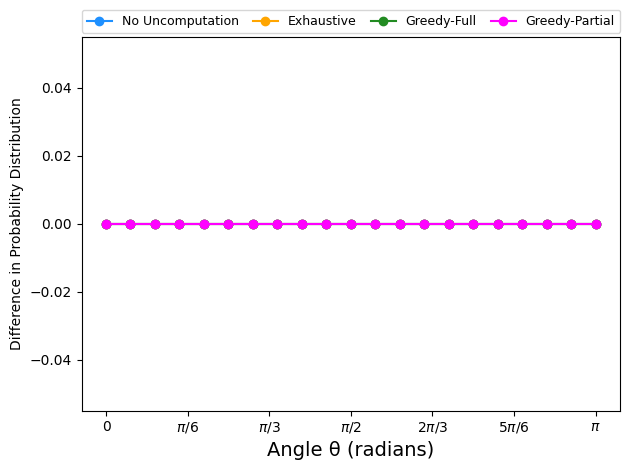

In [28]:
x_axis = []
ex_comp_avg = []
ex_uncomp_avg = []
gf_comp_avg = []
gf_uncomp_avg = []
gp_comp_avg = []
gp_uncomp_avg = []

for i,x in results_dict.items():
    # print(i)
    # print(x)
    # print('-------------------------------')
    x_axis.append(i*numpy.pi*radians)
    ex_comp_avg.append(numpy.average(x.exhaustive_comp_diff))
    ex_uncomp_avg.append(numpy.average(x.exhaustive_uncomp_diff))
    # gf_comp_avg.append(numpy.average(x.greedy_full_comp_diff))
    gf_uncomp_avg.append(numpy.average(x.greedy_full_uncomp_diff))
    # gp_comp_avg.append(numpy.average(x.greedy_partial_comp_diff))
    gp_uncomp_avg.append(numpy.average(x.greedy_partial_uncomp_diff))

plt.plot(x_axis, ex_comp_avg, marker='o', linestyle='-', label='No Uncomputation', color=mcolors.CSS4_COLORS['dodgerblue'], xunits=radians)
plt.plot(x_axis, ex_uncomp_avg, marker='o', linestyle='-', label='Exhaustive', color=mcolors.CSS4_COLORS['orange'], xunits=radians)
plt.plot(x_axis, gf_uncomp_avg, marker='o', linestyle='-', label='Greedy-Full', color=mcolors.CSS4_COLORS['forestgreen'], xunits=radians)
plt.plot(x_axis, gp_uncomp_avg, marker='o', linestyle='-', label='Greedy-Partial', color=mcolors.CSS4_COLORS['magenta'], xunits=radians)


plt.legend(bbox_to_anchor=(0, 1.01, 1, 0.2), loc='lower left',
        ncol=5, mode="expand", borderaxespad=0, fontsize=9)    
xlabel = 'Angle \u03B8 (radians)'
ylabel = 'Difference in Probability Distribution'

plt.xlabel(xlabel, fontsize=14)
plt.ylabel(ylabel)
# plt.title(title)
# fig = plt.show()
# plt.figure(figsize=)
# plt.xlim(x_axis[0]-1, x_axis[-1]+1)
# plt.autoscale(False, axis='x')
# plt.xscale('linear')
plt.tight_layout()
# plt.savefig(f'{image_write_path}/{figname}')
plt.show()
